# ИМПОРТЫ

In [1]:
import os, json, io
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, AutoModelForCausalLM, AdamW, get_scheduler
from peft import get_peft_model, LoraConfig
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from typing import List, Dict, Any, Tuple
import base64
import supervision as sv
import html
from IPython.core.display import HTML

/home/nick/miniconda3/envs/dl/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/nick/miniconda3/envs/dl/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
#pip install supervision==0.25.0

In [ ]:
#import supervision as sv
#print("Supervision version:", sv.__version__)

# Здесь предлагается выполниь загрузку модель заново или воспользоваться чекпоинтом

## BASE

In [2]:
MODEL_ID = 'microsoft/Florence-2-base-ft'
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if 'large' not in MODEL_ID:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True, revision=REVISION)
    base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True, revision=REVISION).to(DEVICE)
else:
    processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
    base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True).to(DEVICE)

## CHKPNT

In [2]:
MODEL_ID = '/home/nick/deeplearning/DIPLOMA/Florence-2-Vision-Language-Model-main/model_checkpoints/epoch_15'
CHECKPOINT = "/home/nick/deeplearning/DIPLOMA/Florence-2-Vision-Language-Model-main/model_checkpoints/epoch_15"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True )
base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True).to(DEVICE)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# ДАТАСЕТ

## JSONL

In [3]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [ ]:
BATCH_SIZE = 5
NUM_WORKERS = 0
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

### НЕ ЗАБУДЬТЕ УКАЗАТЬ ВАШИ ПУТИ ПО АНАЛОГИИ С МОИМИ! ###
train_dataset = DetectionDataset(image_directory_path='/home/nick/deeplearning/DIPLOMA/LEAVES/train/', 
                           jsonl_file_path='/home/nick/deeplearning/DIPLOMA/LEAVES/train/annotations.jsonl')
val_dataset = DetectionDataset(image_directory_path='/home/nick/deeplearning/DIPLOMA/LEAVES/valid/', 
                           jsonl_file_path='/home/nick/deeplearning/DIPLOMA/LEAVES/valid/annotations.jsonl')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

## VOC

In [ ]:
class VOCDataset:
    def __init__(self, image_directory_path: str, annotations_directory_path: str):
        self.image_directory_path = image_directory_path
        self.annotations_directory_path = annotations_directory_path
        self.image_files = [f for f in os.listdir(image_directory_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self) -> int:
        return len(self.image_files)
    
    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.image_files):
            raise IndexError("Index out of range")

        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_directory_path, image_file)
        
        # Получаем соответствующее имя XML файла
        xml_file = os.path.splitext(image_file)[0] + '.xml'
        xml_path = os.path.join(self.annotations_directory_path, xml_file)
        
        try:
            image = Image.open(image_path)
            image = image.convert('RGB')
            # Парсим XML аннотацию
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Получаем размеры изображения из аннотации
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            
            objects = []
            for obj in root.findall('object'):
                name = obj.find('name').text
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                
                objects.append({
                    'name': name,
                    'bbox': [xmin, ymin, xmax, ymax]
                })
            
            # Формируем данные в нужном формате
            prefix = "<OD>"
            suffix_parts = []
            for obj in objects:
                name = obj['name']
                bbox = obj['bbox']
                suffix_parts.append(
                    f"{name}<loc_{bbox[0]}><loc_{bbox[1]}><loc_{bbox[2]}><loc_{bbox[3]}>"
                )
            suffix = "".join(suffix_parts)
            
            data = {
                "image": image_file,
                "prefix": prefix,
                "suffix": suffix,
                "width": width,
                "height": height,
                "objects": objects  # сохраняем оригинальные объекты для совместимости
            }
            
            return image, data
            
        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {e.filename}")
        except Exception as e:
            raise Exception(f"Error processing {image_file}: {str(e)}")


class DetectionDataset(Dataset):
    def __init__(self, image_directory_path: str, annotations_directory_path: str):
        self.dataset = VOCDataset(image_directory_path, annotations_directory_path)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        return data['prefix'], data['suffix'], image


In [ ]:
BATCH_SIZE = 6
NUM_WORKERS = 0
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers
### НЕ ЗАБУДЬТЕ УКАЗАТЬ ВАШИ ПУТИ ПО АНАЛОГИИ С МОИМИ! ###
train_dataset = DetectionDataset(image_directory_path='/home/nick/deeplearning/DIPLOMA/bridges/DATASET/train', 
                           annotations_directory_path='/home/nick/deeplearning/DIPLOMA/bridges/DATASET/train')
val_dataset = DetectionDataset(image_directory_path='/home/nick/deeplearning/DIPLOMA/bridges/DATASET/valid', 
                           annotations_directory_path='/home/nick/deeplearning/DIPLOMA/bridges/DATASET/valid')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

# LoRa Адаптер

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=8,
    #target_modules=["q_proj", "k_proj"],#
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)


Вариант для модели "с нуля"

In [6]:
peft_model = get_peft_model(base_model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076230818042507


Вариант для модели из чекпоинта

In [5]:
peft_model = base_model

In [6]:
torch.cuda.empty_cache()

# ФИШКИ ДЛЯ ВИЗУАЛИЗАЦИИ

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.



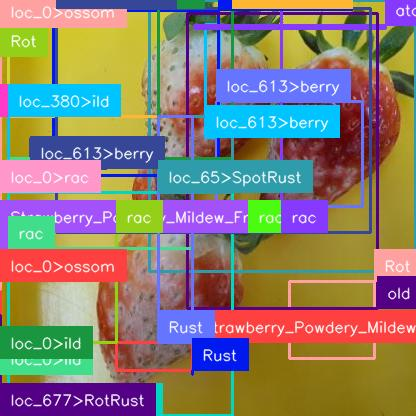
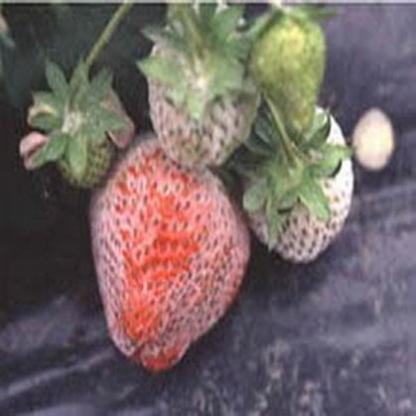
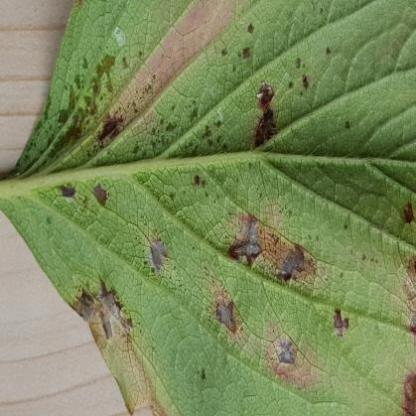
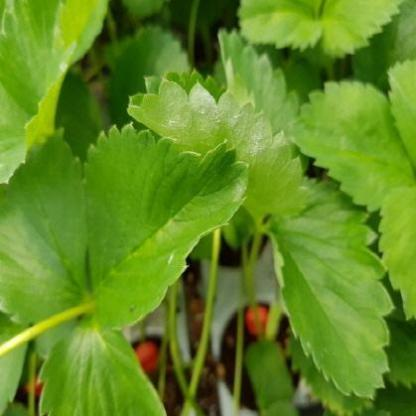

In [7]:
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(base_model, val_dataset, 4)

# ЦИКЛ ОБУЧЕНИЯ

In [ ]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")
            if avg_val_loss < 2:
                render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


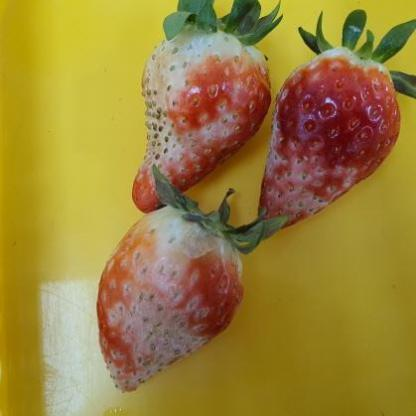
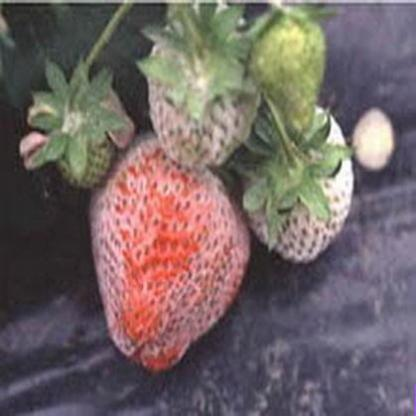
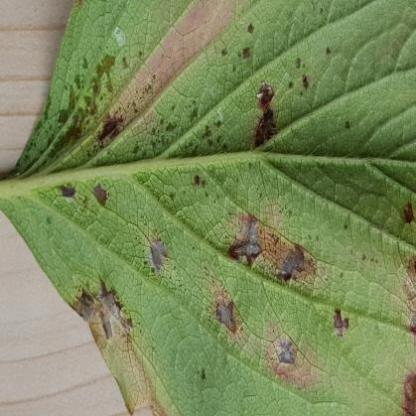
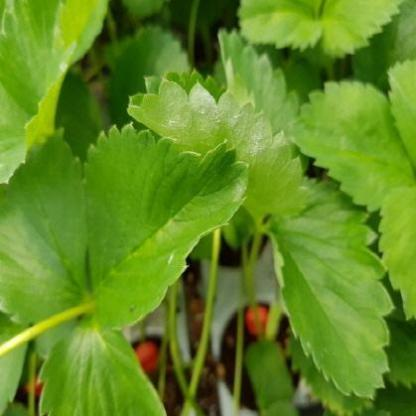
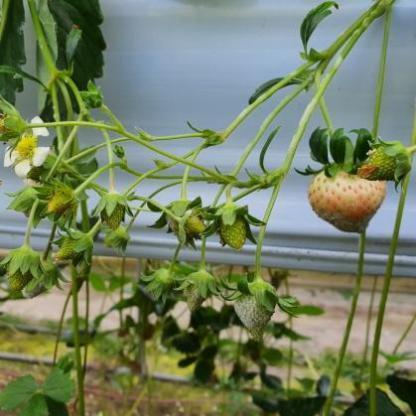
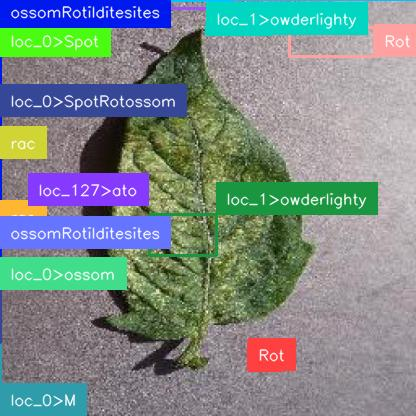

Training Epoch 1/5:   0%|          | 0/581 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [9]:
EPOCHS = 5
LR = 1e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

# СОХРАНИТЬ РЕЗУЛЬТАТ

In [ ]:
peft_model.save_pretrained("/home/nick/deeplearning/DIPLOMA/Florence-2-Vision-Language-Model-main/model_checkpoints")
processor.save_pretrained("/home/nick/deeplearning/DIPLOMA/Florence-2-Vision-Language-Model-main/model_checkpoints")

In [ ]:
render_inference_results(peft_model, train_dataset, 4)